In [1]:
import copy
import os, sys
import numpy as np
import pandas as pd

import joblib

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats.mstats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from scipy.stats import sem

In [2]:
os.chdir('../')

In [3]:
# loa my modules
from src.PMA_SCCA import SCCA
from src.utils import load_pkl
from src.visualise import *
from src.file_io import save_output

In [4]:
dat_path = './data/processed/dict_SCCA_data_prepro_06092017.pkl'
# load data
dataset = load_pkl(dat_path)

In [5]:
FC_yeo7 = dataset['FC_Yeo7']
MRIQ    = dataset['MRIQ']
mot     = dataset['Motion_Jenkinson']
sex     = dataset['Gender']
age     = dataset['Age']

# Cleaning confounds

We first created the confound matrix according to Smith et al. (2015). The confound variables are motion (Jenkinson), sex, and age. We also created squared confound measures to help account for potentially nonlinear effects of these confounds.

In [6]:
from nilearn.signal import clean

In [7]:
confound_raw = np.hstack((mot, sex, age))

# standarlised
z_ = zscore(confound_raw)
# squared measures to help account for potentially nonlinear effects of these confounds
z2_ = z_ ** 2
conf_mat = np.hstack((z_, z2_))

FC_yeo7_clean = clean(np.arctanh(FC_yeo7), confounds=conf_mat, detrend=False, standardize=False)
MRIQ_clean = clean(zscore(MRIQ), confounds=conf_mat, detrend=False, standardize=False)

# K-Fold CV for parameters/model selection

## Decide factor number

In [8]:
X = FC_yeo7_clean
Y = MRIQ_clean


Explained variance %
    n   exp_brain   exp_behaviour
[[  1.      0.66    0.118]
 [  2.      0.695   0.191]
 [  3.      0.741   0.245]
 [  4.      0.774   0.318]
 [  5.      0.807   0.358]
 [  6.      0.843   0.396]
 [  7.      0.863   0.442]
 [  8.      0.882   0.472]
 [  9.      0.905   0.511]
 [ 10.      0.919   0.563]
 [ 11.      0.932   0.591]
 [ 12.      0.942   0.616]
 [ 13.      0.955   0.642]
 [ 14.      0.963   0.671]
 [ 15.      0.972   0.701]
 [ 16.      0.982   0.722]
 [ 17.      0.988   0.742]
 [ 18.      0.991   0.769]
 [ 19.      0.995   0.786]
 [ 20.      0.997   0.803]
 [ 21.      1.      0.821]]


/usr/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


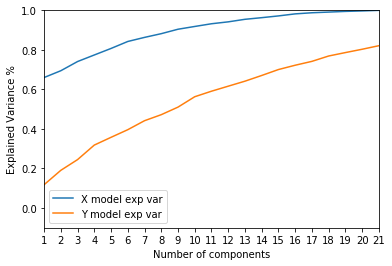

In [9]:
model = SCCA(n_components=None, scale=False, n_iter=50,
                     penX=1, penY=1)
model.model_explained(X, Y)
model.model_evs_plot
# plt.savefig('./reports/gridsearch_correct/select_n_comp.png', dpi=300)

## Penalty selection CV

Grid search range

In [18]:
param_grid = {
    'n_factor':np.array([4]),
    'reg_X': np.array(range(1, 10)) * 0.1,
    'reg_Y': np.array(range(1, 10)) * 0.1,}
out_folds = 5
in_folds = 5

set up inner and outer folds and the parameter grid

In [19]:
KF_out = KFold(n_splits=out_folds, shuffle=True, random_state=1)
KF_in = KFold(n_splits=in_folds, shuffle=True, random_state=1)
para_sets = ParameterGrid(param_grid)

In [20]:
# save the training results of the inner fold
train_mean_evs = np.zeros((out_folds, len(para_sets)))
train_sem_evs  = np.zeros((out_folds, len(para_sets)))
# save the testing results from the outer fold
test_evs = np.zeros(out_folds)

In [21]:
best_model = None
best_ev  = 0

# train-test split
for i, (train_index, test_index) in enumerate(KF_out.split(X, Y)):
    X_train_outer, y_train_outer = X[train_index, :], Y[train_index, :]
    X_test_outer, y_test_outer = X[test_index, :], Y[test_index, :]
    
    X_train_outer, y_train_outer = FC_yeo7[train_index, :], MRIQ[train_index, :]
    X_test_outer, y_test_outer = FC_yeo7[test_index, :], MRIQ[test_index, :]
    confmat_train_outer, confmat_test_outer = confound_raw[train_index, :], confound_raw[test_index, :]
    
    confmat_test_outer = np.hstack((zscore(confmat_test_outer), zscore(confmat_test_outer)**2))
    X_test_outer = clean(np.arctanh(X_test_outer), confounds=confmat_test_outer, detrend=False, standardize=False)
    y_test_outer = clean(zscore(y_test_outer), confounds=confmat_test_outer, detrend=False, standardize=False)
    
    print('Start fold {:01d}'.format(i + 1))
    
    out_best_model = None
    out_best_ev  = 0
    
    for j, parameters in enumerate(iter(para_sets)):   
        train_ev_list = []
        lat_best_ev   = 0
        lat_best_model  = None
        # SET learning parameters
        model = SCCA(n_components=parameters['n_factor'], scale=False, n_iter=50,
                     penX=parameters['reg_X'], penY=parameters['reg_Y'],
                    )
        
        for train_index, test_index in KF_in.split(X_train_outer, y_train_outer):
            # gather train-test data
            X_train_inner, Y_train_inner = X_train_outer[train_index, :], y_train_outer[train_index, :]
            X_test_inner, Y_test_inner = X_train_outer[test_index, :], y_train_outer[test_index, :]
            confmat_train_inner, confmat_test_inner = confmat_train_outer[train_index, :], confmat_train_outer[test_index, :]
            
#             confmat_train_inner = np.hstack((zscore(confmat_train_inner), zscore(confmat_train_inner)**2))
#             X_train_inner = clean(np.arctanh(X_train_inner), confounds=confmat_train_inner, detrend=False, standardize=False)
#             Y_train_inner = clean(zscore(Y_train_inner), confounds=confmat_train_inner, detrend=False, standardize=False)
            
#             confmat_test_inner = np.hstack((zscore(confmat_test_inner), zscore(confmat_test_inner)**2))
#             X_test_inner = clean(np.arctanh(X_test_inner), confounds=confmat_test_inner, detrend=False, standardize=False)
#             Y_test_inner = clean(zscore(Y_test_inner), confounds=confmat_test_inner, detrend=False, standardize=False) 
            
            # fit the training set
            model.fit(X_train_inner, Y_train_inner)
            # calculate sum of R^2 on the validation set
            # model.score returns canonical correlations
            r2_train = model.score(X_test_inner, Y_test_inner)
            
            # dump to list
            train_ev_list.append(r2_train)

            if r2_train > lat_best_ev:
                # select the best model of the current parameter set
                lat_best_model = copy.deepcopy(model)
                lat_best_ev = r2_train 
        
        # Calculate the mean and sem, dump
        train_mean_evs[i, j] = np.mean(train_ev_list)
        train_sem_evs[i, j] = sem(train_ev_list, ddof=1)

        if lat_best_ev > out_best_ev:
            # select the best model of the parameter set 
            out_best_ev = lat_best_ev
            out_best_model = copy.deepcopy(lat_best_model)
        
    # train on the whole training srt and test set and save the R^2
    out_best_model.fit(X_train_outer, y_train_outer)
    r2_test = model.score(X_test_outer, y_test_outer)
    # dump
    test_evs[i] = r2_test
    
    # save the model of the best model of this fold
    joblib.dump(out_best_model, 
            './models/SCCA_confoundclean_fold{:1d}_{:1d}_{:.2f}_{:.2f}_1511.pkl'.format(
                i + 1, out_best_model.n_components, out_best_model.penX, out_best_model.penY)) 
    print('\n==================================================')
    print('\nBest model: \n {:} components,penalty x: {:}, penalty y: {:}\nOOS performance: {}, original:{}'.format(
        out_best_model.n_components, out_best_model.penX,  out_best_model.penY,  r2_test, out_best_ev)) 
    print('==================================================')
    
    if r2_test > best_ev:
        # select the best model across the outer folds
        best_model = copy.deepcopy(out_best_model)
        best_ev = r2_test
    
    
print('\nNew Best model: \n {:} components,penalty x: {:}, penalty y: {:}\nO-O-S performance: {}'.format(
            best_model.n_components, best_model.penX, best_model.penY, best_ev))

joblib.dump(best_model, 
            './models/SCCA_confoundclean_{:1d}_{:.2f}_{:.2f}_1511.pkl'.format(
                best_model.n_components, best_model.penX, best_model.penY)) 

Start fold 1


Best model: 
 4 components,penalty x: 0.1, penalty y: 0.3
OOS performance: 0.205243151901, original:0.633331410158
Start fold 2


Best model: 
 4 components,penalty x: 0.8, penalty y: 0.5
OOS performance: 0.0436045115185, original:0.430301460472
Start fold 3


Best model: 
 4 components,penalty x: 0.6, penalty y: 0.3
OOS performance: 0.253329181082, original:0.343449873993
Start fold 4


Best model: 
 4 components,penalty x: 0.1, penalty y: 0.5
OOS performance: 0.0459353695579, original:0.404572558272
Start fold 5


Best model: 
 4 components,penalty x: 0.5, penalty y: 0.3
OOS performance: 0.0650281854161, original:0.315892614427

New Best model: 
 4 components,penalty x: 0.6, penalty y: 0.3
O-O-S performance: 0.253329181082


['./models/SCCA_confoundclean_4_0.60_0.30_1511.pkl']

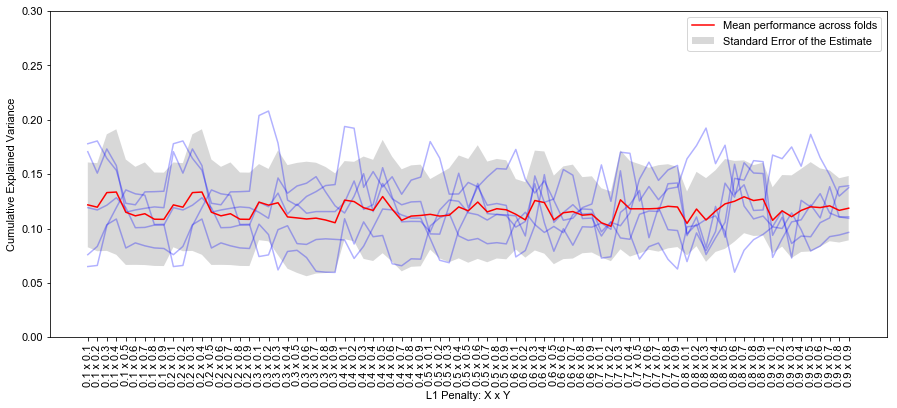

In [14]:
labels = []
for par in iter(para_sets):
    labels.append('{:} x {:}'.format(par['reg_X'], par['reg_Y']))

plt.close('all')
set_text_size(11)
plt.figure(figsize=(15, 6))
for i in range(test_evs.shape[0]):
    plt.plot(range(0 ,len(labels)) , train_mean_evs[i, :], 
         color='b', alpha=0.3)
    
plt.plot(range(0 ,len(labels)) , train_mean_evs.mean(axis=0), 
         color='r', label="Mean performance across folds")
plt.fill_between(range(0 ,len(labels)), 
                 train_mean_evs.mean(axis=0) + train_sem_evs.mean(axis=0), 
                 train_mean_evs.mean(axis=0) - train_sem_evs.mean(axis=0), 
                 facecolor='grey', alpha=0.3, label="Standard Error of the Estimate")
plt.legend()
plt.ylim(0, 0.3)
plt.xlabel('L1 Penalty: X x Y')
plt.xticks(range(0 ,len(labels)), labels, rotation=90)
plt.ylabel('Cumulative Explained Variance')
plt.savefig('./reports/ev_per_para_confoundclean_revision.png', bbox_inches='tight', dpi=150)
plt.show()

In [15]:
set_text_size(14)
u, v = best_model.u, best_model.v

figs = show_results(u, v, dataset['Yeo7_ROIs'], dataset['MRIQ_labels'], rank_v=True, sparse=True)

write_pdf('./reports/revision/bestModel_confoundclean_collection_nested_{0:1d}_{1:.1f}_{2:.1f}_.pdf'.format(
                best_model.n_components, best_model.penX, best_model.penY), figs)

In [16]:
X_scores, Y_scores, df_z = save_output(dataset, best_model, X, Y, path=None)

In [17]:
df_z.to_csv('./data/processed/NYCQ_CCA_score_rev1_{0:1d}_{1:.1f}_{2:.1f}.csv'.format(
            best_model.n_components, best_model.penX, best_model.penY))
df_z.to_pickle('./data/processed/NYCQ_CCA_score_rev1_{0:1d}_{1:.1f}_{2:.1f}.pkl'.format(
            best_model.n_components, best_model.penX, best_model.penY))